#Ejemplos 2.2.2, 2.23 y 2.2.5

*Fecha de última modificación*: 10-oct-22.

*Tesis*: Modelación de la relación entre el cerebro y el comportamiento mediante campos Gaussianos.

*Autor*: Daniela Martínez Aguirre.

*Descripción*: Implementación de campos Gaussianos para la relación Seno ruidosa con tamaño de muestra variable.

$y_i=sen(x_i)+\epsilon_i$ donde $\epsilon_i \sim \mathcal{N}(0,0.1)$.

*Figuras*: 2.1 a 2.4, 2.12 y 2.13.



In [ ]:
#Carga de librerías necesarias 
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

!pip install gpflow
import gpflow

from gpflow.config import default_float
#from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow.utilities import print_summary
import warnings

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Definimos parámetros iniciales.
gpflow.config.set_default_float(np.float64)

#valor de la varianza.
sigma=.1

#Tamaño de muestra, para el ejemplo se tomaron n=5,10,20.
num_train_data=20

#Definamos una semilla para replicar el experimento.
np.random.seed(num_train_data)
tf.random.set_seed(num_train_data)



#Simulación de los datos - Ejemplo 2.2.2

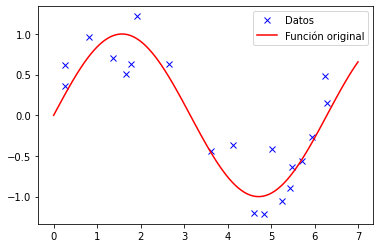

In [ ]:
#Definición del las funciones a estimar

#Función para los ejemplos 2.2.2, 2.2.3 y 2.2.5
def noisy_sin(x):
    return tf.math.sin(x) + np.sqrt(sigma)*tf.random.normal(x.shape,stddev=1, dtype=default_float())

#Función para el ejemplo Ejemplo 2.2.4
def noisy_sin2(x):
    n=len(x)
    y=np.zeros(n)
    for i in range(n):
      if (3 < x[i] < 5):
        y[i]=tf.math.sin(x[i]) + 5
      else:
        y[i]=tf.math.sin(x[i])
    z=tf.convert_to_tensor(y)
    return tf.reshape(z,[n, 1])


#Creación de los datos
X =  np.random.uniform(low=0.0, high=7, size=num_train_data).reshape(-1, 1)
x=np.linspace(0, 7, 100, dtype = np.float64).reshape(-1, 1)

Y = noisy_sin(X) #Datos para los ejemplos 2.2.2, 2.2.3 y 2.2.5
#Y=noisy_sin2(X)  #Datos para los ejemplos 2.2.4
data = (X, Y)

f=tf.math.sin(x) #Función para los ejemplos 2.2.2, 2.2.3 y 2.2.5
#f=noisy_sin2(x)  #Función para los ejemplos 2.2.4

#Gráfica de los datos simulados - Figura 2.1
plt.plot(X, Y, "x", color="blue", label="Datos")
plt.plot(x, f, color="red", label="Función original")
plt.legend()
plt.show()

In [ ]:
#Elección del kernel y sus parámetros
k = gpflow.kernels.SquaredExponential() #Exponencial cuadratico
#k =gpflow.kernels.RationalQuadratic() #Racional cuadrático
#k =gpflow.kernels.Matern12() # Matern 1/2
#k=gpflow.kernels.Matern52() # Matern 5/2
#k=gpflow.kernels.Matern32() # Matern 3/2
#k=gpflow.kernels.Polynomial() #Kernel polinomial

#Imprime detalle del kernel a utilizar
print_summary(k)


╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


# Creación de la dn a priori - Ejemplo 2.2.2

In [ ]:
#Simulación de 3 dn a priori con los parámetros 0, K(X,X)
priori1=np.random.multivariate_normal(mean=np.zeros(100),cov=k(x,x).numpy())
priori2=np.random.multivariate_normal(mean=np.zeros(100),cov=k(x,x).numpy())
priori3=np.random.multivariate_normal(mean=np.zeros(100),cov=k(x,x).numpy())

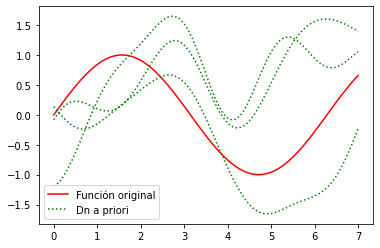

In [ ]:
#Gráfica de las dn´s a priori-Figura 2.2
plt.plot(x, f, color="red", label="Función original")
plt.plot(x, priori1, color="green", label="Dn a priori", linestyle=":")
plt.plot(x, priori2, color="green", linestyle=":")
plt.plot(x, priori3, color="green", linestyle=":")
plt.legend()
plt.show()

#Dn posterior - Ejemplo 2.2.2

In [ ]:
#calulo de los parámetros de la dn posterior utilizando los hiperparámetros iniciales

#Media posterior
m1=k(x,X).numpy()
m2=np.linalg.inv(k(X,X).numpy()+np.identity(num_train_data)*sigma)
m3=np.dot(m1,m2)
mean_posterior=np.dot(m3,Y).T[0]

#Varianza posterior
m4=k(x,x).numpy()
m5=k(X,x).numpy()
var_posterior=m4-np.dot(m3,m5)

#Simulación de 50 muestras de la posterior
YY=np.random.multivariate_normal(mean=mean_posterior.T,cov=var_posterior, size=50)


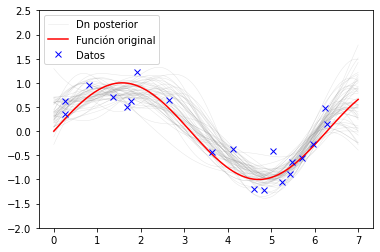

In [ ]:
#Gráficas de la dn posterior con la función original y los datos-Figura 2.3
plt.plot(x, YY.T, color="gray", linewidth=0.5, alpha=0.2)
plt.plot(x, YY.T[:,0], color="gray", label="Dn posterior",  linewidth=0.5, alpha=0.2)
plt.plot(x, f, color="red", label="Función original")
plt.plot(X, Y, "x", color="blue", label="Datos")
plt.legend()
plt.ylim(-2, 2.5)
plt.show()

#Predicción - Ejemplo 2.2.3


In [ ]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

In [ ]:
#Summary del modelo
m.likelihood.variance.assign(.1)
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     1   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     1   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │     0.1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

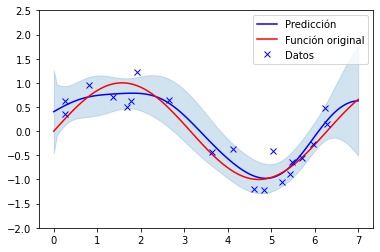

In [ ]:
#Predicción y_hat utilizando los hiperparámetros iniciales - Figura 2.4
mean, var = m.predict_f(x)
var=var+np.identity(len(var))*sigma
plt.plot(x, mean_posterior, color="blue", label="Predicción ")
plt.plot(x,f, color="red", label="Función original")
plt.plot(X, Y, "x", color="blue", label="Datos")
plt.fill_between(
    x[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
plt.legend()
plt.ylim(-2, 2.5)
plt.show()

In [ ]:
#Valor de la -log verosimulitud
m.training_loss().numpy()

12.256808770219525

In [ ]:
#Puedo asignar valores iniciales
#m.likelihood.variance.assign(0.01)
#m.kernel.lengthscales.assign(1)

#Cálculo de hiperparámetros - Ejemplo 2.2.5

In [ ]:
#Estimación de hiperparámetros por el método del gradiente
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.5106  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.29472 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.08218 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [ ]:
#Imprime los valores de hiperparámetros optimizados
k

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,0.5106
SquaredExponential.lengthscales,Parameter,Softplus,,True,(),float64,1.29472


In [ ]:
#Cálculo de los parámetros de la posterior con los hiperparámetros estimados

#Media posterior
k=m.kernel
sigma=m.likelihood.variance
m1=k(x,X).numpy()
m2=np.linalg.inv(k(X,X).numpy()+np.identity(num_train_data)*sigma)
m3=np.dot(m1,m2)
mean_posterior=np.dot(m3,Y).T[0]

#Varianza posterior
m4=k(x,x).numpy()
m5=k(X,x).numpy()
var_posterior=m4-np.dot(m3,m5)

YY=np.random.multivariate_normal(mean=mean_posterior.T,cov=var_posterior, size=50)

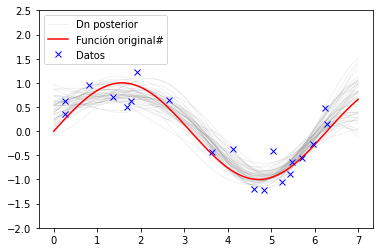

In [ ]:
#Gráficas de la dn posterior con la función original y los datos
plt.plot(x, YY.T, color="gray", linewidth=0.5, alpha=0.2)
plt.plot(x, YY.T[:,0], color="gray", label="Dn posterior",  linewidth=0.5, alpha=0.2)
plt.plot(x, f, color="red", label="Función original#")
plt.plot(X, Y, "x", color="blue", label="Datos")
plt.legend()
plt.ylim(-2, 2.5)
plt.show()

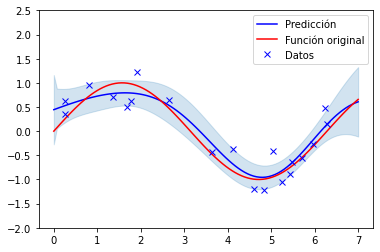

In [ ]:
#Predicción y_hat utilizando los hiperparámetros estimados - Figura 2.12 y 2.13
mean, var = m.predict_f(x)
var=var+np.identity(len(var))*sigma
plt.plot(x, mean_posterior, color="blue", label="Predicción ")
plt.plot(x, f, color="red", label="Función original")
plt.plot(X, Y, "x", color="blue", label="Datos")
plt.fill_between(
    x[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
plt.legend()
plt.ylim(-2, 2.5)
plt.show()

In [ ]:
m.training_loss().numpy()

10.824989427887239